Ссылка на данные: https://drive.google.com/drive/folders/1Nm1XbW95qb-5AGv4yIvAkCuAQC9CXiOc?usp=sharing

In [ ]:
!gdown 1hB36sReQ0PgOEy1ie0uTs0NHEKY8F1e1
!gdown 1rZLZQfpUsPIh3nMl3GbOfqJDsjhtEG1i

Downloading...
From: https://drive.google.com/uc?id=1hB36sReQ0PgOEy1ie0uTs0NHEKY8F1e1
To: /content/train.csv
100% 241M/241M [00:03<00:00, 67.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1rZLZQfpUsPIh3nMl3GbOfqJDsjhtEG1i
To: /content/test.csv
100% 60.1M/60.1M [00:01<00:00, 44.4MB/s]


In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
import pandas as pd
from tqdm import tqdm_notebook
import cv2
from IPython.display import clear_output

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Flatten
import tensorflow as tf
import keras
from sklearn.metrics import accuracy_score, f1_score
from keras import backend as K

from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False


EMOTIONS = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
N_CLASSES = len(EMOTIONS)

In [ ]:
# каждое изображение растянуто в строку в таблице
# преобразуем в привычный массив, не создавая папки с изображениями явным образом,
# т.к. метод .fit() работает гораздо быстрее чем .fit_generator()

img_width, img_height = (48,48)

def str_to_image(image_blob):
    image_string = image_blob[0].split(' ')
    image_data = np.asarray(image_string, dtype=np.uint8).reshape(48,48)
    return image_data

def csv_to_array(csv):
    X = csv.pixels.values
    X = np.apply_along_axis(str_to_image, 1, X[:,None])/255.
    X = X[...,None]
    return X

train = pd.read_csv('train.csv') # для обучения и валидации
test = pd.read_csv('test.csv') # для сабмита на кагл

y_train = train.emotion.values
X_train = csv_to_array(train)
X_test= csv_to_array(test)

y_train = tf.keras.utils.to_categorical(y_train, num_classes=N_CLASSES)

In [ ]:
print(X_train.shape, '\n', y_train.shape, '\n', X_test.shape)

(28709, 48, 48, 1) 
 (28709, 7) 
 (7178, 48, 48, 1)


In [ ]:
y_train

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [ ]:
train.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [ ]:
test.head()

,pixels
0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...
1,156 184 198 202 204 207 210 212 213 214 215 21...
2,69 118 61 60 96 121 103 87 103 88 70 90 115 12...
3,205 203 236 157 83 158 120 116 94 86 155 180 2...
4,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...


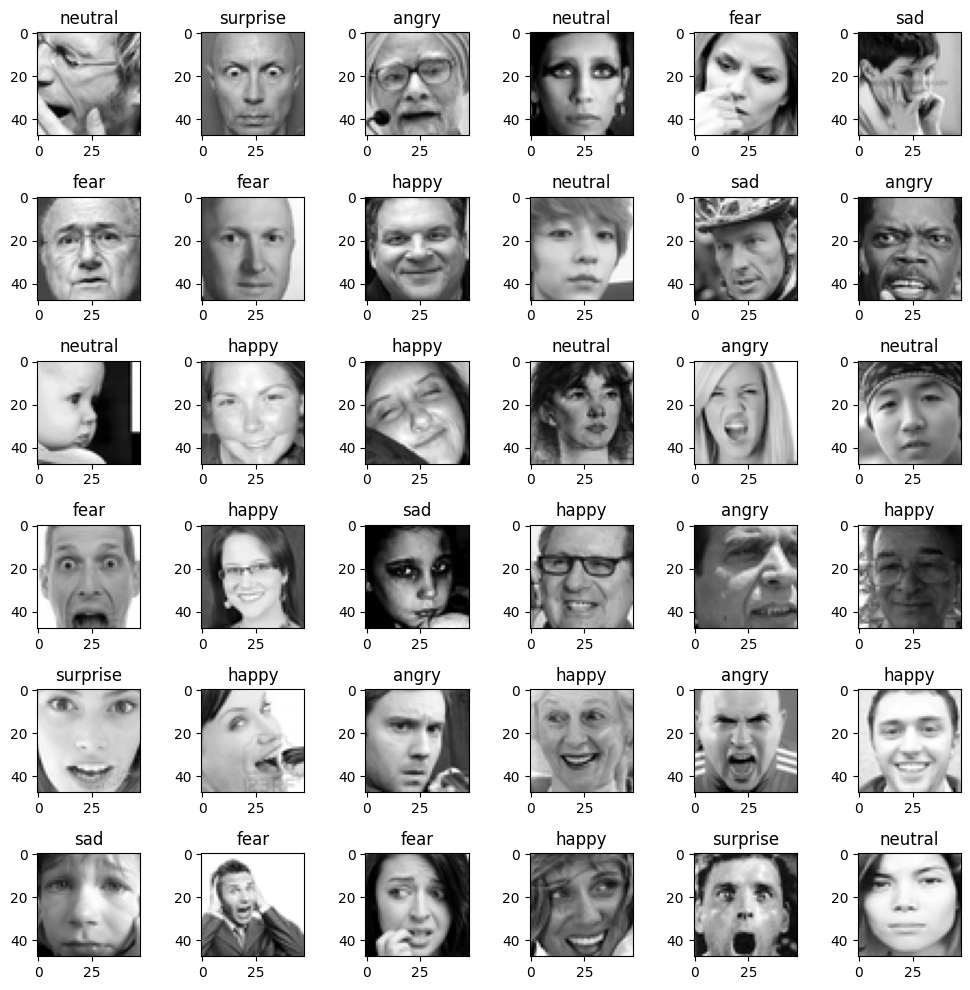

In [ ]:
# посмотрим как выглядят изображения
N_IMAGES_TO_PLOT = 36
fig, axes = plt.subplots(nrows=np.sqrt(N_IMAGES_TO_PLOT).astype(int),
                         ncols = np.sqrt(N_IMAGES_TO_PLOT).astype(int),
                         figsize=(10,10))

rand_indx = np.random.choice(np.arange(N_IMAGES_TO_PLOT), size=N_IMAGES_TO_PLOT, replace=False)
for ax, emotion_index, img in zip(axes.flatten(), train.emotion.values[rand_indx], X_train[rand_indx]):
    img = img[:,:,0] # [48,48,1] -> [48,48]
    ax.imshow(img, cmap='gray')
    emotion = EMOTIONS[emotion_index]
    ax.set_title(emotion)
plt.tight_layout()
plt.show()

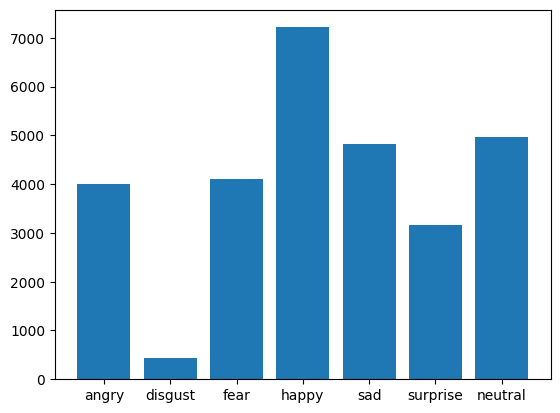

In [ ]:
# посмотрим насколько сбалансированны классы в обучающей выборке
train_count = train.groupby('emotion').count()
plt.bar(x = EMOTIONS,
        height=train_count.values.flatten())
plt.show()

Виден сильный дисбаланс между классом `disguist` и остальными

In [ ]:

if K.image_data_format() == 'channels_first':
    input_shape = (1, img_width, img_height)
else:
    input_shape = (img_width, img_height, 1)

model = Sequential()

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024))
model.add(Dropout(0.2))
model.add(Dense(N_CLASSES))
model.add(Activation('softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])

N_EPOCHS = 100
history_cnn = model.fit(X_train,
                        y_train,
                        batch_size=128,
                        epochs=N_EPOCHS,
                        workers = 400)



Epoch 1/100
225/225 [==============================] - 8s 5ms/step - loss: 1.9153 - accuracy: 0.2754
Epoch 2/100
225/225 [==============================] - 1s 5ms/step - loss: 1.7145 - accuracy: 0.3166
Epoch 3/100
225/225 [==============================] - 1s 5ms/step - loss: 1.6926 - accuracy: 0.3270
Epoch 4/100
225/225 [==============================] - 1s 5ms/step - loss: 1.6803 - accuracy: 0.3335
Epoch 5/100
225/225 [==============================] - 1s 5ms/step - loss: 1.6738 - accuracy: 0.3360
Epoch 6/100
225/225 [==============================] - 1s 5ms/step - loss: 1.6662 - accuracy: 0.3406
Epoch 7/100
225/225 [==============================] - 1s 5ms/step - loss: 1.6881 - accuracy: 0.3155
Epoch 8/100
225/225 [==============================] - 1s 5ms/step - loss: 1.6729 - accuracy: 0.3308
Epoch 9/100
225/225 [==============================] - 1s 5ms/step - loss: 1.6935 - accuracy: 0.3223
Epoch 10/100
225/225 [==============================] - 1s 6ms/step - loss: 1.6824 - accura

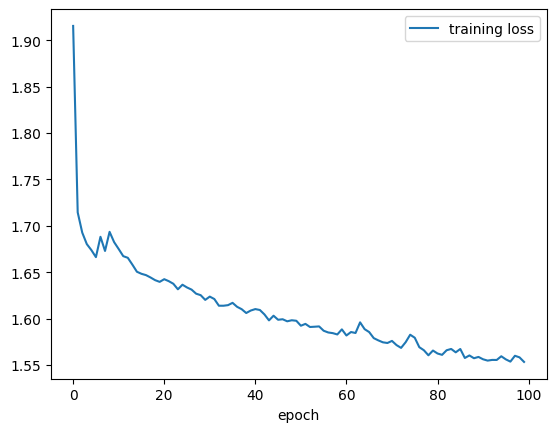

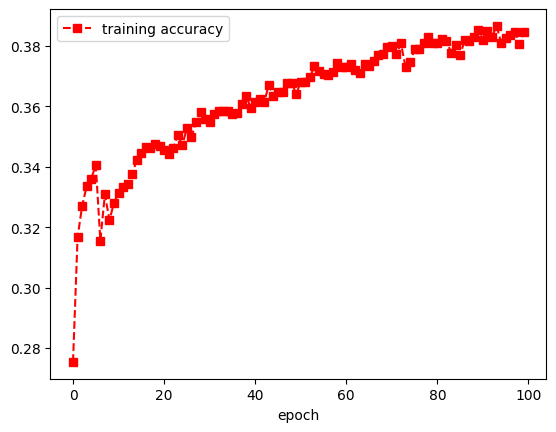

In [ ]:
plt.figure()
plt.plot(history_cnn.history['loss'], label='training loss')
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(history_cnn.history['accuracy'], '--s', color='r', label='training accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

### Как сделать лучше?

 - Начните со сверточной нейронной сети: Conv2D -> Activation -> ReLU -> Conv2D ... -> Dense
 - Transfer Learning: взять предобученную на большом датасете модель и слегка дообучить ее, подстроив под новую задачу. Это возможно, т.к. большая часть слоев нейронной сети, обученной для классификации изображений, извлекает признаки из изображения, а последний, линейный слой, выступает в роли классификатора. Подробнее о том как это использовать - [здесь](https://neurohive.io/ru/tutorial/transfer-learning-keras/)
 - Аугментация данных: небольшой размер датасета и большое количество параметров модели (что характерно для нейронных сетей) способствует переобучению. Проблему недостатка данных можно решить трансформацией батча на этапе обучения, например, вращая изображения или меняя уровень яркости. Подробнее - [здесь](https://machinelearningmastery.com/image-augmentation-deep-learning-keras/)  
 - Попробуйте убрать дисбаланс в данных, использовав простой oversampling: например для каждого класса добавьте в него случайно выбранные из него-же данные.

In [ ]:
# вычисляет и скачивает файл для submission на kaggle
def submit(model, X_test):

    prediction=model.predict(X_test,  workers=400)

    pred_classes = prediction.argmax(-1)
    df = pd.DataFrame(data = {'Id':np.arange(len(pred_classes)),
                              'Category':pred_classes})

    df.to_csv('submission.csv', index=False)
    files.download('submission.csv')

submit(model, X_test)

225/225 [==============================] - 0s 2ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>